Jet Nebuliser particle release (jn_ad_mp)
====================================================

### Authors: Ciarraí, James, Miriam, Marco, Martín López-García

1. **Diffusion equation:**

The function piecewise_diffusion_model solves the one-dimensional diffusion equation with a source term and decay using the Crank-Nicolson method. It models the propagation of aerosol particles from a nebulizer in a room.

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - \lambda C + \frac{E}{V} + Q(x, t)
$$

where:

$C(x,t)$ is the concentration of particles as a function of position $x$ and time $t$ (units: $\mu g/m^3$),
$D$ is the diffusion coefficient (units: $m^2/s$),
$\lambda$ is the decay rate of the particles (units: $1/s$),
$E$ is the emission rate of the nebulizer (units: $\mu g/s$),
$V$ is the volume of the room (units: $m^3$).

2. The point source term, Q(x, t), when the nebulizer is on:

$$
Q(x, t) = 
\begin{cases}
\frac{Q_0}{dx} \delta(x) &  \text{if } t_{on} \leq t < t_{off} \\
0 & \text{otherwise}
\end{cases}
$$

3. Discretized version of the diffusion equation with the point source term using Cranck-Nicolson method:

$$
C_{i}^{n+1} = C_{i}^{n} + \frac{D \Delta t}{2\Delta x^2}(C_{i+1}^{n+1} - 2C_{i}^{n+1} + C_{i-1}^{n+1}) - \frac{\lambda C_{i}^{n+1}\Delta t}{2} + \frac{E\Delta t}{2V} + \frac{D \Delta t}{2\Delta x^2}(C_{i+1}^{n} - 2C_{i}^{n} + C_{i-1}^{n}) - \frac{\lambda C_{i}^{n}\Delta t}{2} 
$$

   where:
   - $C^n_i$ represents the concentration at position $i$ and time step $n$
   - $\Delta x$ is the spatial step size
   - $\Delta t$ is the time step size
   - $E$ is the generation rate (non-zero only when the nebulizer is on)
   - $V$ is the fixed volume of the room
   - $\lambda$ is the decay constant

## Boundary Conditions


Neumann boundary conditions (zero-flux or zero-gradient conditions) are implemented at the edges of the domain. These conditions imply that there is no flux of particles across the boundaries, which is appropriate when the boundaries represent insulating or reflective walls.


# 2. Advective-Diffusion equation

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - v \frac{\partial C}{\partial x}-\lambda C + \frac{E}{V}
$$

Let's assume that $v$ is fixed.
$$
C_{i}^{n+1} = C_{i}^{n} + \frac{D \Delta t}{2\Delta x^2}(C_{i+1}^{n+1} - 2C_{i}^{n+1} + C_{i-1}^{n+1}) - \frac{v \Delta t}{4\Delta x}(C_{i+1}^{n+1} - C_{i-1}^{n+1}) - \frac{\lambda C_{i}^{n+1}\Delta t}{2} + \frac{E\Delta t}{2V} + \frac{D \Delta t}{2\Delta x^2}(C_{i+1}^{n} - 2C_{i}^{n} + C_{i-1}^{n}) - \frac{v \Delta t}{4\Delta x}(C_{i+1}^{n} - C_{i-1}^{n}) - \frac{\lambda C_{i}^{n}\Delta t}{2}
$$



In [2]:
# install if not done yet
!pip install pyabc --quiet
#!pip install pyabc[pyarrow]
#import sqlalchemy
#from sqlalchemy import create_engine

In [3]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy as sp
import pandas as pd
import pyabc
from scipy.linalg import solve_banded

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

0.1 Import and Organise Data
----
We have the data for mean concentrations at 2m and 0.8m.


In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/jn_ad_mp_BOTH_distances.txt', sep='\t',header=0)
#remove leading space from time column
data["time"] = data["time"].apply(lambda x: x.strip())
data["time"] = data["time"].apply(lambda x: datetime.strptime(x, "%M:%S")) #convert to datetime
data["fraction_of_hour"] = data["time"].apply(lambda x: (x.minute+x.second/60) / 60) #convert to fraction of hour
measurement_data_2 = data['0_8m']
measurement_data_8 = data['2m']
measurement_times = data['fraction_of_hour'] 

observed_data = {
    "C1": measurement_data_8,
    "C2": measurement_data_2,
}

print(data)

                   time      0_8m  0_8m_stdev        2m  2m_stdev  \
0   1900-01-01 00:00:20  0.003946    0.001905  0.005134  0.001880   
1   1900-01-01 00:00:40  0.004332    0.002963  0.005232  0.002768   
2   1900-01-01 00:01:00  0.004116    0.001542  0.005169  0.003253   
3   1900-01-01 00:01:20  0.006855    0.006092  0.006125  0.002677   
4   1900-01-01 00:01:40  0.004316    0.001948  0.004628  0.002475   
..                  ...       ...         ...       ...       ...   
130 1900-01-01 00:43:40  0.112286    0.015655  0.140815  0.021630   
131 1900-01-01 00:44:00  0.112199    0.015106  0.139307  0.020947   
132 1900-01-01 00:44:20  0.110953    0.015773  0.137048  0.020477   
133 1900-01-01 00:44:40  0.109970    0.016301  0.137475  0.020110   
134 1900-01-01 00:45:00  0.111132    0.014321  0.137425  0.019247   

     fraction_of_hour  
0            0.005556  
1            0.011111  
2            0.016667  
3            0.022222  
4            0.027778  
..                ...  
130

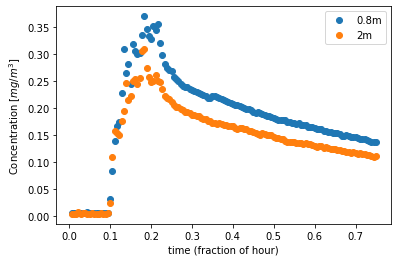

In [255]:
#plot data 0.8m and 2m
plt.plot(measurement_times, measurement_data_8, 'o', label='0.8m')  
plt.plot(measurement_times, measurement_data_2, 'o', label='2m')
plt.xlabel('time (fraction of hour)')
plt.ylabel('Concentration [$mg/m^3$]')
plt.legend()
plt.show()

as well as the time points at whith to evaluate

Define the conditions :

 - for 0<$t$<5 minutes: background concentration 
 - for 5<$t$<14 minutes: nebuliser on
 - for 14<$t$<45 minutes: decay

## 0.1 Model Definition - Diffusion only

In [172]:
def piecewise_diffusion_model(D, dx, dt, t_intervals, E, lambda_):
    x_max = 3  # This should be the maximum x position in your simulation
    x_center = x_max/2  # This should be the x position of the nebulizer
    x_values = np.arange(0, x_max, dx)
    nx = int(x_max / dx)  # Calculate number of spatial points
    i_center = np.argmin(np.abs(x_values - x_center))
    
    C_all = []
    V = 44.34  # fixed room volume
    C0 = np.full((nx,), 0.00540826)  # Use this as the initial concentration

    # Define the band matrix for Crank-Nicolson
    A_upper = np.zeros(nx-2)
    A_upper[:-1] = -D*dt/(4*dx**2)
    A_mid = np.full(nx-2, 1 + D*dt/(2*dx**2) + lambda_*dt/2)
    A_lower = np.zeros(nx-2)
    A_lower[1:] = -D*dt/(4*dx**2)
    A = np.vstack((A_upper, A_mid, A_lower))

    for t_start, t_end in t_intervals:
        t = np.arange(t_start, t_end, dt)

        C = np.zeros((len(t), nx))
        C[0, :] = C0

        for n in range(0, len(t) - 1):
            # Calculate the right-hand side for Crank-Nicolson
            b = C[n, :-2] * D*dt/(4*dx**2) + (1 - D*dt/(2*dx**2) - lambda_*dt/2) * C[n, 1:-1] + C[n, 2:] * D*dt/(4*dx**2)
            
            # Neumann boundary conditions
            b[0] -= C[n, 1]*D*dt/(4*dx**2)
            b[-1] -= C[n, -2]*D*dt/(4*dx**2)
            
            # Solve the system of equations for the next time step
            C[n + 1, 1:-1] = solve_banded((1, 1), A, b)

            # Add emission at the center when the nebulizer is on
            if 5 / 60 <= t[n] < 14 / 60:
                C[n + 1, i_center] += E * dt / V
                
        C_all.append(C)
        C0 = C[-1, :]

    C_all = np.concatenate(C_all, axis=0)
    sigma = 0.001
    C_all += np.random.normal(0, sigma, size=C_all.shape)

    return C_all


0.2 Model Definition - Advective-Diffusion
=====

In [3]:
def piecewise_advection_diffusion_model(D, dx, dt, t_intervals, E, lambda_, v):
    x_max = 5
    x_center = x_max/2
    x_values = np.arange(0, x_max, dx)
    nx = int(x_max / dx)
    i_center = np.argmin(np.abs(x_values - x_center))
    
    C_all = []
    V = 44.34
    C0 = np.full((nx,), 0.00540826)

    #print(D, dx, dt, v)
    A_upper = np.zeros(nx-2)
    A_upper[:-1] = -D*dt/(4*dx**2) + v*dt/(4*dx)
    A_mid = np.full(nx-2, 1 + D*dt/(2*dx**2) + lambda_*dt/2)
    A_lower = np.zeros(nx-2)
    A_lower[1:] = -D*dt/(4*dx**2) - v*dt/(4*dx)
    A = np.vstack((A_upper, A_mid, A_lower))


    for t_start, t_end in t_intervals:
        t = np.arange(t_start, t_end, dt)

        C = np.zeros((len(t), nx))
        C[0, :] = C0

        for n in range(0, len(t) - 1):
            b = C[n, :-2] * D*dt/(4*dx**2) - C[n, :-2] * v*dt/(4*dx) + (1 - D*dt/(2*dx**2) - lambda_*dt/2) * C[n, 1:-1] + C[n, 2:] * D*dt/(4*dx**2) + C[n, 2:] * v*dt/(4*dx)

            # Neumann boundary conditions
            b[0] -= C[n, 1]*D*dt/(4*dx**2) - C[n, 1]*v*dt/(4*dx)
            b[-1] -= C[n, -2]*D*dt/(4*dx**2) + C[n, -2]*v*dt/(4*dx)
            
            # Solve the system of equations for the next time step
            C[n + 1, 1:-1] = solve_banded((1, 1), A, b)

            # Add emission at the center when the nebulizer is on
            if 5 / 60 <= t[n] < 14 / 60:
                C[n + 1, i_center] += E * dt / V
                
        C_all.append(C)
        C0 = C[-1, :]

    C_all = np.concatenate(C_all, axis=0)
    sigma = 0.001
    C_all += np.random.normal(0, sigma, size=C_all.shape)

    return C_all

def piecewise_advection_diffusion_model(D, dx, dt, t_intervals, E, lambda_, v):
    x_max = 5
    x_center = x_max/2
    x_values = np.arange(0, x_max, dx)
    nx = int(x_max / dx)
    i_center = np.argmin(np.abs(x_values - x_center))
    
    C_all = []
    V = 44.34
    C0 = np.full((nx,), 0.00540826)

    # Define the Gaussian distribution
    #sigma = 0.3
    #gauss = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_values - x_center) / sigma)**2)

    # Normalize the Gaussian so that its integral is equal to the amount introduced per time step
    #gauss *= E * dt / V / (np.sum(gauss) * dx)

    A_upper = np.zeros(nx-2)
    A_upper[:-1] = -D*dt/(4*dx**2) + v*dt/(4*dx)
    A_mid = np.full(nx-2, 1 + D*dt/(2*dx**2) + lambda_*dt/2)
    A_lower = np.zeros(nx-2)
    A_lower[1:] = -D*dt/(4*dx**2) - v*dt/(4*dx)
    A = np.vstack((A_upper, A_mid, A_lower))

    for t_start, t_end in t_intervals:
        t = np.arange(t_start, t_end, dt)

        C = np.zeros((len(t), nx))
        C[0, :] = C0

        for n in range(0, len(t) - 1):
            b = C[n, :-2] * D*dt/(4*dx**2) - C[n, :-2] * v*dt/(4*dx) + (1 - D*dt/(2*dx**2) - lambda_*dt/2) * C[n, 1:-1] + C[n, 2:] * D*dt/(4*dx**2) + C[n, 2:] * v*dt/(4*dx)

            # Apply Neumann boundary conditions
            b[0] += (D*dt/(2*dx**2) - v*dt/(2*dx)) * C[n, 0]
            b[-1] += (D*dt/(2*dx**2) + v*dt/(2*dx)) * C[n, -1]

            # Solve the system of equations for the next time step
            C[n + 1, 1:-1] = solve_banded((1, 1), A, b)

            # Apply Neumann boundary conditions
            C[n + 1, 0] = C[n + 1, 1] - (D * dt / dx + v * dt) * (C[n + 1, 1] - C[n, 1])
            C[n + 1, -1] = C[n + 1, -2] + (D * dt / dx - v * dt) * (C[n + 1, -2] - C[n, -2])

            # Add emission at the center when the nebulizer is on
            if 5 / 60 <= t[n] < 14 / 60:
                C[n + 1, i_center] += E * dt / V
                
        C_all.append(C)
        C0 = C[-1, :]

    C_all = np.concatenate(C_all, axis=0)
    sigma = 0.001
    C_all += np.random.normal(0, sigma, size=C_all.shape)

    return C_all


 


### Extract only speficic points in space

But we only want to extract the data from the simulation based on what's measured

In [4]:
def extract_concentration_at_positions(C_all, measurement_times, dt,dx):
    """
    Extract concentration values at the required positions and times from the diffusion model output.
    
    Parameters
    ----------
    C_all : array-like
        Array of concentration values from the diffusion model.
    measurement_times : array-like
        Array of measurement times.
    dt : float
        Time step size.
    dx : float
        Spatial step size.

    Returns
    -------
    C1, C2 : array-like
        Arrays of concentration values at positions x1 and x2 at the given times.
    """
    
    x_max = 5  # This should be the maximum x position in your simulation
  
    x_values = np.arange(0, x_max, dx)

    x1 = 2.5+0.8  # Position where concentration is measured (you can change this value)
    x2 = 2.5+2  # Position where concentration is measured (you can change this value)

    i1 = np.argmin(np.abs(x_values - x1))
    i2 = np.argmin(np.abs(x_values - x2))

    # Find the indices of the time instances corresponding to measurement_times
    time_indices = np.array([np.argmin(np.abs(t - np.arange(C_all.shape[0]) * dt)) for t in measurement_times])

    C1 = C_all[time_indices, i1]
    C2 = C_all[time_indices, i2]
    
    #nebulizer_on_indices = np.where((measurement_times >= 5/60) & (measurement_times < 14/60))[0]
    return C1, C2#, nebulizer_on_indices


# An example of the model - Parameters chosen by eye

### Concentration at 2m and 0.8m over time

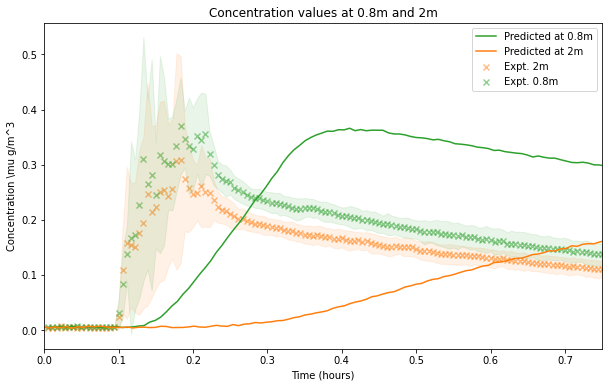

In [10]:
# Define time intervals for the piecewise simulation
t_intervals = [
    (0, 5 / 60),
    (5 / 60, 14 / 60),
    (14 / 60, 60 / 60)
]
dx = 0.004    # Adjust spatial step size
dt = 1/3600  # Adjust time step size

D = 5#1e-2  # Adjust diffusion coefficient
lambda_ = 1e-2
E = 90000 # Adjust generation rate
V = 44.34  # Adjust room volume
v=.3
C_all = piecewise_advection_diffusion_model(D, dx, dt, t_intervals, E,lambda_,v)
# Extract the concentration values at the required positions
C1, C2 = extract_concentration_at_positions(C_all,measurement_times, dt,dx)
# Create a time array for the x-axis
t_max = sum([interval[1] - interval[0] for interval in t_intervals])
time = np.linspace(0, t_max, len(C1))
# Plot the concentration values
plt.figure(figsize=(10, 6))
plt.plot(time, C1, label="Predicted at 0.8m",color="C2")
plt.plot(time, C2, label="Predicted at 2m",color="C1")
#plot mesurement_data_2 against measurment_times using the same color as above but with marker and alpa=0.5
plt.scatter(measurement_times, measurement_data_2, color="C1", label='Expt. 2m',marker="x",alpha=0.5)
plt.scatter(measurement_times, measurement_data_8, color="C2", label='Expt. 0.8m',marker="x",alpha=0.5)
plt.fill_between(measurement_times, data['0_8m'] - data["0_8m_stdev"], data['0_8m'] + data["0_8m_stdev"],color='C1', alpha=0.1)
plt.fill_between(measurement_times, data['2m'] - data["2m_stdev"], data['2m'] + data["2m_stdev"],color='C2', alpha=0.1)
#plt.plot(measurement_times, measurement_data_2, color="C1", label='Expt. 2m')
#plt.plot(measurement_times, measurement_data_8, color="C2", label='Expt. 0.8m')
plt.xlabel("Time (hours)")
# x axis limit is 0 to 0.75
plt.xlim(0,0.75)
plt.ylabel("Concentration \mu g/m^3")
plt.title("Concentration values at 0.8m and 2m")
plt.legend()
plt.show()

In [8]:
data

,time,0_8m,0_8m_stdev,2m,2m_stdev,fraction_of_hour
0,1900-01-01 00:00:20,0.003946,0.001905,0.005134,0.001880,0.005556
1,1900-01-01 00:00:40,0.004332,0.002963,0.005232,0.002768,0.011111
2,1900-01-01 00:01:00,0.004116,0.001542,0.005169,0.003253,0.016667
3,1900-01-01 00:01:20,0.006855,0.006092,0.006125,0.002677,0.022222
4,1900-01-01 00:01:40,0.004316,0.001948,0.004628,0.002475,0.027778
...,...,...,...,...,...,...
130,1900-01-01 00:43:40,0.112286,0.015655,0.140815,0.021630,0.727778
131,1900-01-01 00:44:00,0.112199,0.015106,0.139307,0.020947,0.733333
132,1900-01-01 00:44:20,0.110953,0.015773,0.137048,0.020477,0.738889
133,1900-01-01 00:44:40,0.109970,0.016301,0.137475,0.020110,0.744444


### Concentration over space at various times

In [12]:
def extract_concentration_at_time(C_all, t_target, dt):
    """
    Extract concentration values at the required time from the diffusion model output.

    Parameters
    ----------
    C_all : array-like
        Array of concentration values from the diffusion model.
    t_target : float
        Target time.
    dt : float
        Time step size.

    Returns
    -------
    C_target : array-like
        Array of concentration values at the target time.
    """
    t_index = np.argmin(np.abs(t_target - np.arange(C_all.shape[0]) * dt))
    C_target = C_all[t_index, :]
    return C_target


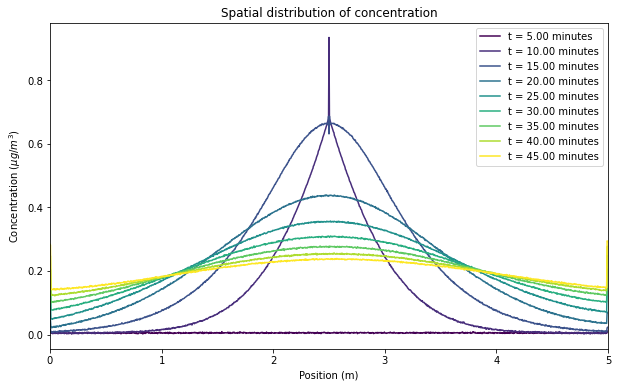

In [14]:

import matplotlib.pyplot as plt
import numpy as np
# Parameters for your simulation
dx = 0.004  # Adjust spatial step size
dt = 1/3600  # Adjust time step size

x_max = 5  # This should be the maximum x position in your simulation
#dx = 0.04    # Spatial step size
x_center = x_max/2  # This should be the x position of the nebulizer
x_values = np.arange(0, x_max, dx)

# Example parameters
t_intervals = [(0, 5 / 60), (5 / 60, 14 / 60), (14 / 60, 60 / 60)]
D = 6#1e-2  # Adjust diffusion coefficient
lambda_ = 1e-2
E = 80000 # Adjust generation rate
V = 44.34  # Adjust room volume
v=-.3

C_all = piecewise_advection_diffusion_model(D, dx, dt, t_intervals, E,lambda_,v)
#piecewise_diffusion_model(D, dx, dt, t_intervals, E,lambda_)

# Set up the figure
plt.figure(figsize=(10, 6))

# Define the times at which you want to plot the concentration
plot_times = np.arange(5, 46, 5) / 60  # Times in hours

# Create a colormap
colors = cm.viridis(np.linspace(0, 1, len(plot_times)))

# Loop over the plot times
for t_target, color in zip(plot_times, colors):
    # Extract the concentration values at this time
    C_target = extract_concentration_at_time(C_all, t_target, dt)

    # Plot the spatial distribution of concentration at this time
    plt.plot(x_values, C_target, color=color, label=f"t = {t_target * 60:.2f} minutes")

# Add plot of steady state concentration E/(lambda*V)
#plt.plot(x_values, E/(lambda_*V)*np.ones_like(x_values), color="C0", label="Steady state")
# Add labels, title, and legend
plt.xlabel("Position (m)")
# x axis limits between 1m and 2m   
plt.xlim(0, 5)
plt.ylabel("Concentration ($\mu g/m^3$)")
plt.title("Spatial distribution of concentration")
plt.legend()

# Show the plot
plt.show()

## 1.2 Check Model Numerical Stability 

In [38]:
def check_numerical_stability(D_range, lambda_range, E_range, v_range, dx, dt):
    unstable_params = []
    for D in D_range:
        for lambda_ in lambda_range:
            for E in E_range:
                for v in v_range:
                    # Check the Courant-Friedrichs-Lewy (CFL) condition for the advection-diffusion equation
                    cfl_condition = D*dt/(dx**2) + abs(v)*dt/dx
                    if cfl_condition > 0.5:
                        unstable_params.append((D, lambda_, E, v))
    return unstable_params

# Define parameter ranges
D_range = np.linspace(1e-6, 8, 50)
lambda_range = np.linspace(1e-7, 3, 50)
E_range = np.linspace(1e4, 8e5, 50)
v_range = np.linspace(-.5, .5, 50)

# Define dx and dt
dx = 0.004
dt = 1/3600

# Check if the numerical stability condition is satisfied for all parameter ranges
unstable_params = check_numerical_stability(D_range, lambda_range, E_range, v_range, dx, dt)

if len(unstable_params) == 0:
    print("The numerical stability condition is satisfied for all parameter ranges.")
else:
    print(f"The numerical stability condition is not satisfied for these parameters: {unstable_params}.")


In [37]:
# Find the ranges of the unstable parameters
def get_unstable_ranges(unstable_params):
    # Get the min and max of each parameter from the unstable parameter sets
    D_unstable = [param[0] for param in unstable_params]
    lambda_unstable = [param[1] for param in unstable_params]
    E_unstable = [param[2] for param in unstable_params]
    v_unstable = [param[3] for param in unstable_params]

    # Calculate the range for each parameter
    D_range_unstable = (min(D_unstable), max(D_unstable))
    lambda_range_unstable = (min(lambda_unstable), max(lambda_unstable))
    E_range_unstable = (min(E_unstable), max(E_unstable))
    v_range_unstable = (min(v_unstable), max(v_unstable))

    # Return the ranges
    return D_range_unstable, lambda_range_unstable, E_range_unstable, v_range_unstable

# Get the ranges of unstable parameters
D_range_unstable, lambda_range_unstable, E_range_unstable, v_range_unstable = get_unstable_ranges(unstable_params)

print(f"D_range_unstable: {D_range_unstable}")
print(f"lambda_range_unstable: {lambda_range_unstable}")
print(f"E_range_unstable: {E_range_unstable}")
print(f"v_range_unstable: {v_range_unstable}")


D_range_unstable: (0.8888897777777778, 8.0)
lambda_range_unstable: (1e-07, 3.0)
E_range_unstable: (10000.0, 800000.0)
v_range_unstable: (-0.5, 0.5)


## 1.3 ABC inference

## 2.0 Set up the ABC algorithm

Set up the ABC algorithm - we will use the ABC-SMC algorithm
This runs millions of different combinations of parameters and compares the model output to the data. If the distance between the predicted curves and the observed data is 'small enough', then the parameters are accepted. The distance is calculated using the sum of the squared differences between the model and the data.

## 2.1 Distance function

In [78]:
def mse(y_true, y_pred):
    return np.sum(abs(y_true-y_pred))#np.sum((y_true - y_pred)**2)


In [79]:
#def distance(simulation, data):
#    return (np.absolute((data["Concentration"] - simulation["Concentration"]))).sum()

def distance_function(measurement, simulation):
    #C1_sim, C2_sim = extract_concentration_at_positions(simulation["C_all"])
    error_C1 = mse(measurement["C1"], simulation["C1"])
    error_C2 = mse(measurement["C2"], simulation["C2"])
    error = 0.5 * (error_C1 + error_C2)
    return error

# New distance function to account for time when nebuliser is on with fixed weights prioritising nebuliser on time

def distance_function_weighted(measurement, simulation, nebulizer_on_indices):
    mse_C1 = mse(measurement["C1"], simulation["C1"])
    mse_C2 = mse(measurement["C2"], simulation["C2"])

    nebulizer_on_weight = 0.75
    decay_weight = 1 - nebulizer_on_weight

    error_C1_nebulizer_on = mse_C1[nebulizer_on_indices].sum() / nebulizer_on_indices.size
    error_C1_decay = mse_C1[np.setdiff1d(np.arange(mse_C1.size), nebulizer_on_indices)].sum() / (mse_C1.size - nebulizer_on_indices.size)

    error_C2_nebulizer_on = mse_C2[nebulizer_on_indices].sum() / nebulizer_on_indices.size
    error_C2_decay = mse_C2[np.setdiff1d(np.arange(mse_C2.size), nebulizer_on_indices)].sum() / (mse_C2.size - nebulizer_on_indices.size)

    error_C1 = nebulizer_on_weight * error_C1_nebulizer_on + decay_weight * error_C1_decay
    error_C2 = nebulizer_on_weight * error_C2_nebulizer_on + decay_weight * error_C2_decay

    error = 0.5 * (error_C1 + error_C2)
    return error

# separate distance functions for C1 and C2

def distance_C1(x, x_0):
    return mse(x["C1"], x_0["C1"]).sum()

def distance_C2(x, x_0):
    return mse(x["C2"], x_0["C2"]).sum()



In [17]:
# Define the model function that is compatible with pyabc
def abc_model(params):
    dx = 0.004
    dt = 1 / 3600
    t_intervals = [(0, 5 / 60), (5 / 60, 14 / 60), (14 / 60, 0.75)]

    C_all = piecewise_advection_diffusion_model(params["D"], dx, dt, t_intervals, params["E"], params["lamda_"],params['v'])#piecewise_diffusion_model(params["D"], dx, dt, t_intervals, params["E"], params["lamda_"])
    
    # Extract the concentration values at the required time positions
    dt_d = 0.00555556
    t_d = np.arange(0.005556, 0.75, dt_d)

    # add 0.75 to the time grid
    t_d = np.append(t_d, 0.750000)
    C1, C2 = extract_concentration_at_positions(C_all,measurement_times, dt,dx)
    return {"C1":C1,"C2":C2} #{"C_all": C_all}


Define the prior distributions for the parameters. We will use uniform priors for all parameters.

In [15]:
# Define prior distributions for the parameters
prior = pyabc.Distribution(
    D=pyabc.RV("uniform", 1e-7, 10),
    E=pyabc.RV("uniform", 1e4, 1e6),
    lamda_=pyabc.RV("uniform", 1e-7, 3),
    v=pyabc.RV("uniform", -.2, 2)
)

This is the function that will be called by the ABC algorithm. It takes a set of parameters and returns the distance between the model and the data.

In [18]:
#from functools import partial
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import QuantileEpsilon

from functools import partial

def distance_C1(x, x_0, on_indices, off_indices):
    mse_on = mse(x["C1"][on_indices], x_0["C1"][on_indices]).sum()
    mse_off = mse(x["C1"][off_indices], x_0["C1"][off_indices]).sum()
    return mse_on + mse_off

def distance_C2(x, x_0, on_indices, off_indices):
    mse_on = mse(x["C2"][on_indices], x_0["C2"][on_indices]).sum()
    mse_off = mse(x["C2"][off_indices], x_0["C2"][off_indices]).sum()
    return mse_on + mse_off

nebulizer_on_indices = np.where((measurement_times >= 5/60) & (measurement_times < 14/60))[0]
nebulizer_off_indices = np.where(measurement_times >= 14/60)[0]

# Pre-fill the nebulizer_on_indices and nebulizer_off_indices arguments
distance_C1_partial = partial(distance_C1, on_indices=nebulizer_on_indices, off_indices=nebulizer_off_indices)
distance_C2_partial = partial(distance_C2, on_indices=nebulizer_on_indices, off_indices=nebulizer_off_indices)

#PCMAD with Manhattan Distance
scale_log_file_pcmad = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,  # new, previously mad
    scale_log_file=scale_log_file_pcmad,
)

# Initialize the ABC-SMC model
abc = pyabc.ABCSMC(
    models=abc_model,
    parameter_priors=prior,
    distance_function=distance_adaptive,#pyabc.AdaptiveAggregatedDistance([distance_C1_partial, distance_C2_partial]),#, #partial(distance_function, observed_data),
    population_size= AdaptivePopulationSize(start_nr_particles=1000, mean_cv=0.2), #population_size=1000,
    #transitions=pyabc.LocalTransition(k_fraction=.3),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True)#,
    #eps=QuantileEpsilon(alpha=0.5)#pyabc.MedianEpsilon(500, median_multiplier=0.95),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [6]:
observed_data_np = {key: np.array(value) for key, value in observed_data.items()}


In [5]:
observed_data_np

{'C1': 0      0.005134
 1      0.005232
 2      0.005169
 3      0.006125
 4      0.004628
          ...   
 130    0.140815
 131    0.139307
 132    0.137048
 133    0.137475
 134    0.137425
 Name: 2m, Length: 135, dtype: float64,
 'C2': 0      0.003946
 1      0.004332
 2      0.004116
 3      0.006855
 4      0.004316
          ...   
 130    0.112286
 131    0.112199
 132    0.110953
 133    0.109970
 134    0.111132
 Name: 0_8m, Length: 135, dtype: float64}

This tells the abc model where the experimental data is.

In [21]:
#abc.new(db_path, {"Concentration": measurement_data, "stdev": data['stdev']})

# Run the ABC-SMC inference
abc.new(db_path, observed_data_np)
history = abc.run(max_nr_populations=25)

ABC.History INFO: Start <ABCSMC id=48, start_time=2023-05-03 15:19:31>
ABC INFO: Calibration sample t = -1.
ABC.Distance INFO: Features ['C1:7', 'C1:17', 'C1:18', 'C1:19', 'C1:20', 'C1:21', 'C2:0', 'C2:3', 'C2:17', 'C2:18', 'C2:19', 'C2:20', 'C2:21', 'C2:22', 'C2:23', 'C2:24', 'C2:25', 'C2:26', 'C2:27', 'C2:28', 'C2:29', 'C2:30', 'C2:31', 'C2:32', 'C2:33', 'C2:34', 'C2:35', 'C2:36', 'C2:37', 'C2:38', 'C2:39', 'C2:40', 'C2:41', 'C2:42', 'C2:43', 'C2:44', 'C2:45', 'C2:46', 'C2:47', 'C2:48', 'C2:49', 'C2:50', 'C2:51', 'C2:52', 'C2:53'] (ixs=[  7  17  18  19  20  21 135 138 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188]) have a high bias.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.73201621e+02.
ABC INFO: Accepted: 1000 / 2126 = 4.7037e-01, ESS: 1.0000e+03.
ABC.Adaptation INFO: Change nr particles 1000 -> 19
ABC.Distance INFO: Features ['C1:7', 'C1

KeyboardInterrupt: 

Plot marginal histograms of the posterior distributions of the three parameters

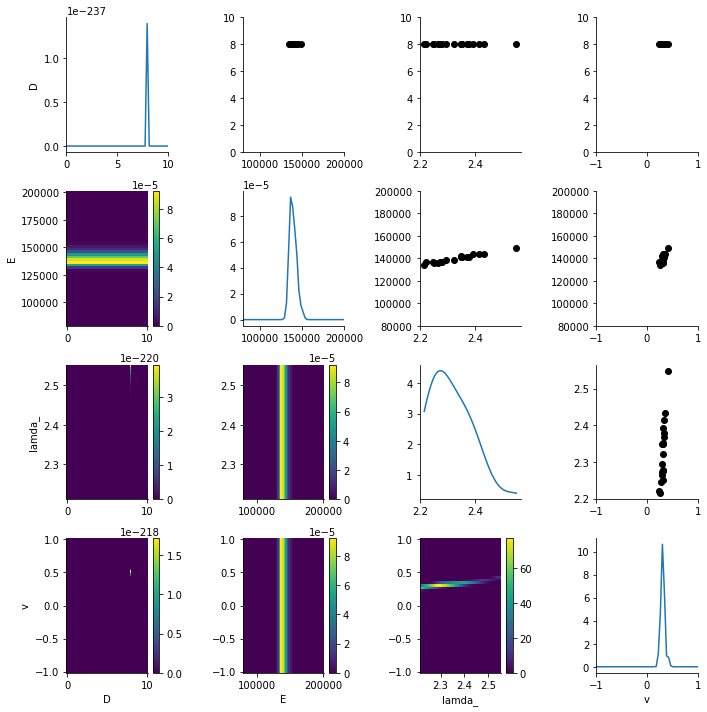

In [433]:
#rom pyabc.visualization import plot_kde_matrix

limits = dict(D=(0,10),E=(8e4, 20e4), lambda_=(0, 5),v=(-1,1))
#df, w = h.get_distribution(m=0)
#plot_kde_matrix(df, w, limits=limits);

#plt.show()

# Plot parameter distributions
df, w = history.get_distribution()
pyabc.visualization.plot_kde_matrix(df, w, limits=limits)
plt.show()



Looking at the data

In [183]:
df.describe()

name,D,E,lamda_,v
count,236.000000,236.000000,236.000000,236.000000
mean,0.000371,260.019113,0.006397,-0.515892
std,0.000076,25.730869,0.004092,0.266153
min,0.000231,207.710125,0.000025,-0.999228
25%,0.000310,239.540409,0.002884,-0.727617
50%,0.000360,258.403266,0.005883,-0.521447
75%,0.000433,281.405613,0.009203,-0.294399
max,0.000590,329.384990,0.018613,-0.024625


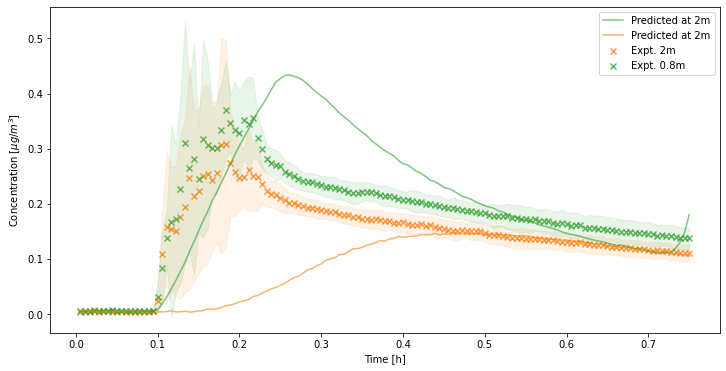

In [415]:
# Create a summary table of parameter values
df, w = history.get_distribution(m=0, t=history.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
#df = df.round(3)

# Extract the best 50 parameter sets based on the weights
best_50 = df.iloc[:50].values.tolist()

# Plot observed data
plt.figure(figsize=(12, 6))

plt.scatter(measurement_times, measurement_data_2, color="C1", label='Expt. 2m',marker="x",alpha=0.75)
plt.scatter(measurement_times, measurement_data_8, color="C2", label='Expt. 0.8m',marker="x",alpha=0.75)
# Plot the best 50 predictions
for i in range(1):
    params = df.iloc[i].to_dict()
    C_all = piecewise_advection_diffusion_model(params["D"], dx, dt, t_intervals, params["E"], params["lamda_"], params["v"])
    C1_sim, C2_sim = extract_concentration_at_positions(C_all, measurement_times, dt,dx)
    plt.plot(measurement_times, C1_sim, 'C2-', alpha=0.6, label='Predicted at 2m')
    plt.fill_between(measurement_times, data['0_8m'] - data["0_8m_stdev"], data['0_8m'] + data["0_8m_stdev"],color='C1', alpha=0.1)
    plt.fill_between(measurement_times, data['2m'] - data["2m_stdev"], data['2m'] + data["2m_stdev"],color='C2', alpha=0.1)
    plt.plot(measurement_times, C2_sim, 'C1-', alpha=0.6, label='Predicted at 2m')

plt.xlabel("Time [h]")
plt.ylabel("Concentration [$\mu g/m^3$]")
plt.legend()
plt.show()


# 3.0 Sensitivity Analysis 



In [208]:
#pip install SALib

  Using cached salib-1.4.7-py3-none-any.whl (757 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 3.6 MB/s eta 0:00:00
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
def model_wrapper(param_values):
    # Reshape param_values into 2D array if necessary
    if len(param_values.shape) == 1:
        param_values = param_values.reshape(1, -1)

    # Initialize array to store results
    results = np.empty(param_values.shape[0])

    # Loop over parameter sets
    for i in range(param_values.shape[0]):
        D, lambda_, E, v = param_values[i, :]
        C_all = piecewise_advection_diffusion_model(D, dx, dt, t_intervals, E, lambda_, v)
        C1_sim, C2_sim = extract_concentration_at_positions(C_all, measurement_times, dt,dx)
        # Take maximum concentration value
        results[i] = np.var(C1_sim)
    
    return results


In [27]:
from SALib.sample import saltelli 
from SALib.analyze import dgsm

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['D', 'lambda_', 'E', 'v'],
    'bounds': [[1e-5, 8], [1e-7, 3], [1e4, 8e5], [-.2, .2]]
}

# Generate samples
param_values = saltelli.sample(problem, 256)

# Run model
Y = model_wrapper(param_values)

# Perform analysis
Si = dgsm.analyze(problem, param_values, Y, print_to_console=True)


# Plot the results


/var/folders/nj/1xvlt_gx5cnbgn9v19jkqlzc0000gn/T/ipykernel_49311/1031127036.py:12: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 256)


              vi    vi_std      dgsm  dgsm_conf
D        0.04275  0.293106  4.851313   0.025265
lambda_      inf       NaN       inf        NaN
E            inf       NaN       inf        NaN
v            inf       NaN       inf        NaN


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/SALib/analyze/dgsm.py:113: RuntimeWarning: divide by zero encountered in true_divide
  dfdx = ((perturbed - base) / x_delta) ** 2
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/SALib/analyze/dgsm.py:122: RuntimeWarning: divide by zero encountered in true_divide
  dfdx = ((perturbed - base) / x_delta) ** 2


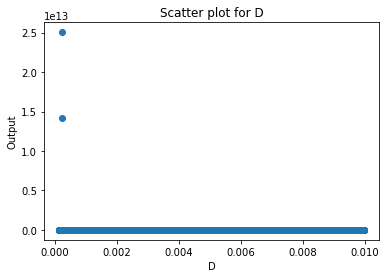

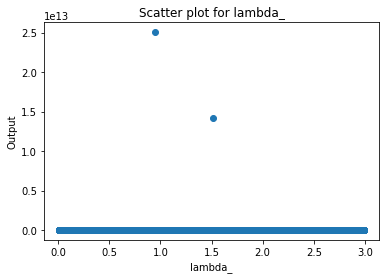

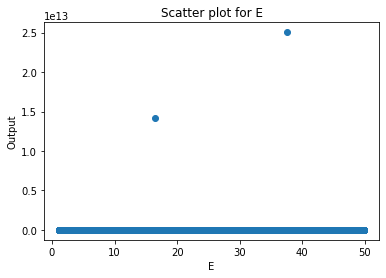

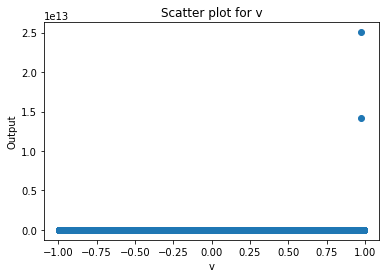

In [228]:
for i, name in enumerate(problem['names']):
    plt.figure()
    plt.scatter(param_values[:, i], Y)
    plt.title(f"Scatter plot for {name}")
    plt.xlabel(name)
    plt.ylabel("Output")
    plt.show()


# OLD

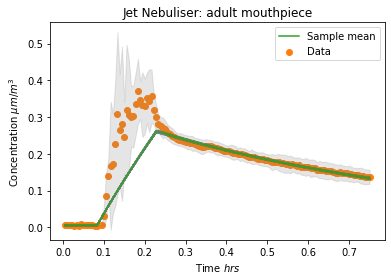

In [82]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.01)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
#plt.errorbar(measurement_times,measurement_data,yerr=data["stdev"], label ="Data",color='C1')
plt.fill_between(measurement_times, measurement_data - data["stdev"], measurement_data + data["stdev"],color='gray', alpha=0.2)
plt.xlabel('Time $hrs$')
plt.ylabel('Concentration $\mu m/m^3$')
plt.title('Jet Nebuliser: adult mouthpiece')
plt.legend()
plt.show()

# remove stdandard deviation because it penalises central part.
# what about room volume?
# balance data points between each phases
# 

Summary table of parameters

In [165]:
# Create a summary table of parameter values
df, w = history.get_distribution(m=0, t=history.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.describe()


name,D,E,lamda_,w
count,500.000000,500.000000,500.000000,500.000000
mean,0.057264,10.301090,4.636444,0.001990
std,0.027041,0.446816,0.281311,0.001241
min,0.000000,8.850000,3.309000,0.001000
25%,0.036000,10.000750,4.485750,0.001000
50%,0.059500,10.307500,4.704000,0.002000
75%,0.079250,10.610250,4.848000,0.002000
max,0.100000,11.583000,5.000000,0.012000
